In [40]:
import pandas as pd
import numpy as np

#from folium import plugins
#import folium

#import seaborn as sns
#sns.set(rc={'figure.figsize':(18.7,7.27)})

import matplotlib.pyplot as plt
%matplotlib inline

# Analysis correlation pay house and pay listing in Barcelona city

- Analyzed the year 2017 because it was the most complete on both the case side and the listing side


In [11]:
# user-defined functions

def fix_price (value):
    try:
        value = value.replace("$", '').replace(",", '')
        value = float(value)
        return value
    except: return np.nan  

#### Listings

In [14]:
listing_barcelona = pd.read_csv("listings_append.csv", low_memory=False)

In [15]:
listing_barcelona['price'] = listing_barcelona['price'].apply(lambda x : fix_price(x))

In [16]:
listing_barcelona['date_year_quarter'] = pd.to_datetime(listing_barcelona['date_year_month'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
listing_barcelona['date_year_quarter'] = pd.to_datetime(listing_barcelona['date_year_quarter'])
listing_barcelona['date_year_quarter']=listing_barcelona['date_year_quarter'].dt.to_period('Q')

listing_barcelona['year'] = listing_barcelona['date_year_quarter'].dt.year
listing_barcelona['quarter'] = listing_barcelona['date_year_quarter'].dt.quarter

#### Reviews

In [17]:
review_barcelona = pd.read_csv("reviews_barcellona.csv")

In [18]:
review_barcelona['date_year_quarter'] = pd.to_datetime(review_barcelona['date_year_month'], format='%Y-%m-%d').dt.strftime('%Y-%m-%d')
review_barcelona['date_year_quarter'] = pd.to_datetime(review_barcelona['date_year_quarter'])
review_barcelona['date_year_quarter']=review_barcelona['date_year_quarter'].dt.to_period('Q')

review_barcelona['year'] = review_barcelona['date_year_quarter'].dt.year
review_barcelona['quarter'] = review_barcelona['date_year_quarter'].dt.quarter

#### house prices

In [20]:
pay_house_2017 = pd.read_csv("2017_lloguer_preu_trim.csv", dtype=str)

In [21]:
pay_house_2017['date_year_month'] = pay_house_2017['Any'] + '-' + pay_house_2017['Trimestre']

pay_house_2017 = pay_house_2017[['Any','Trimestre','Nom_Districte','Preu','date_year_month']]
pay_house_2017.columns=['year','quarter','neighbourhood_group_cleansed','price_house','date_year_month']

pay_house_2017['price_house'] = pay_house_2017['price_house'].astype(float)
pay_house_2017['year'] = pay_house_2017['year'].astype(int)
pay_house_2017['quarter'] = pay_house_2017['quarter'].astype(int)

pay_house_2017 = pay_house_2017.groupby(["neighbourhood_group_cleansed", 'year','quarter'])[["price_house"]].mean()
pay_house_2017 = pay_house_2017.reset_index()

In [22]:
pay_house_2017.head()

,neighbourhood_group_cleansed,year,quarter,price_house
0,Ciutat Vella,2017,1,415.052500
1,Ciutat Vella,2017,2,426.770000
2,Ciutat Vella,2017,3,442.870000
3,Ciutat Vella,2017,4,439.440000
4,Eixample,2017,1,477.834167


In [24]:
#### check neighbourhood
#np.unique(pay_house_2020['neighbourhood_group_cleansed'])
#np.unique(listing_barcelona.neighbourhood_group_cleansed)

In [25]:
### join listing

listing_final = listing_barcelona.merge(pay_house_2017,
                                        on =['year','quarter','neighbourhood_group_cleansed'],
                                        how='left')                    

In [28]:
listing_final.head(1)

,index,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,...,requires_license,jurisdiction_names,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,date_year_quarter,year,quarter,price_house
0,0,18674,https://www.airbnb.com/rooms/18674,20210412154247,2021-04-13,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,...,NaN,NaN,NaN,NaN,NaN,NaN,2021Q2,2021,2,NaN


## ANALYSIS

### Descritive

In [29]:
listing_final = listing_final[(listing_final.year == 2017)]

review_final = review_barcelona[(review_barcelona.year == 2017)]

In [30]:
### join review file
listing_final = listing_final[['id','price_house','neighbourhood_group_cleansed',
                               'year','quarter','price','latitude','longitude']]

listing_final.columns=['listing_id','price_house','neighbourhood_group_cleansed',
                       'year','quarter','price','latitude','longitude']


df_analysis=review_final.merge(listing_final,on =['listing_id','quarter','year'],how='left')

In [31]:
df = df_analysis.groupby(['latitude','longitude','neighbourhood_group_cleansed'])[['reviewer_id']].count().reset_index()
df = df.groupby(['latitude','longitude','neighbourhood_group_cleansed'])[['reviewer_id']].sum().reset_index()

In [32]:
df.head()

,latitude,longitude,neighbourhood_group_cleansed,reviewer_id
0,41.351938,2.148480,Sants-Montjuïc,35
1,41.353093,2.141918,Sants-Montjuïc,2
2,41.353240,2.147595,Sants-Montjuïc,8
3,41.353790,2.146846,Sants-Montjuïc,23
4,41.357095,2.135831,Sants-Montjuïc,13


In [33]:
df.neighbourhood_group_cleansed.unique()

array(['Sants-Montjuïc', 'Les Corts', 'Ciutat Vella', 'Eixample',
       'Sant Martí', 'Sarrià-Sant Gervasi', 'Gràcia', 'Horta-Guinardó',
       'Sant Andreu', 'Nou Barris'], dtype=object)

In [ ]:
# Create a map object of the city of Barcelona
barcelona_map = folium.Map(location=[41.38879, 2.15899], zoom_start=12)

# Instantiate a mark cluster object
obj = plugins.MarkerCluster().add_to(barcelona_map)

for lat, lng, label in zip(df.latitude, df.longitude, df.reviewer_id.astype(str)):
    if label!='0':
        folium.Marker(
            location=[lat, lng],
            #icon=label,
            popup='Number contract' + ':' + label,
        ).add_to(obj)

# Display map
barcelona_map

In [ ]:
### create dataframe quarter

In [35]:
df_1 = df_analysis.groupby(["neighbourhood_group_cleansed", 'quarter'])[["reviewer_id"]].count().reset_index()

In [36]:
df_2 = df_analysis.groupby(["neighbourhood_group_cleansed", 'quarter'])[["price_house"]].median().reset_index()

In [37]:
df_3 = df_analysis.groupby(["neighbourhood_group_cleansed", 'quarter'])[["price"]].median().reset_index()

In [38]:
df_quarter = pd.concat([df_1, df_2['price_house'], df_3['price']],axis=1)

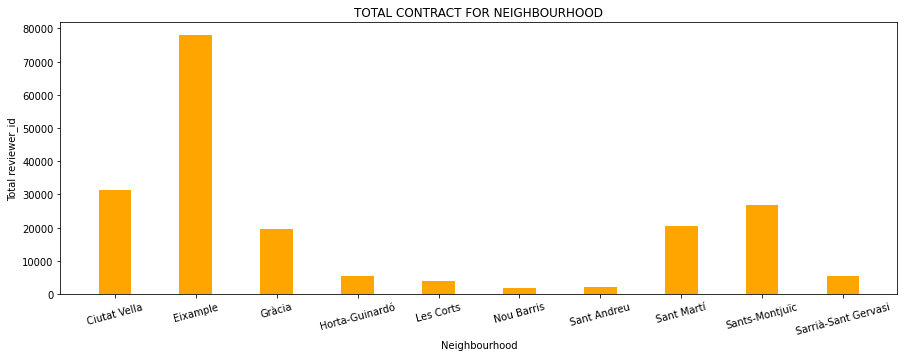

In [60]:
graph = pd.pivot_table(data = df_quarter,
                       index=['neighbourhood_group_cleansed'],
                       #columns = "ASSET_LOCATION",
                       values=["reviewer_id"], 
                       aggfunc="sum",
                       )

graph = graph.reset_index()

fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(graph.neighbourhood_group_cleansed, graph.reviewer_id, color ='orange',
        width = 0.4)
 
plt.xlabel("Neighbourhood")
plt.xticks(fontsize=10, rotation=15)
plt.ylabel("Total reviewer_id")
plt.title("TOTAL CONTRACT FOR NEIGHBOURHOOD")
plt.show()

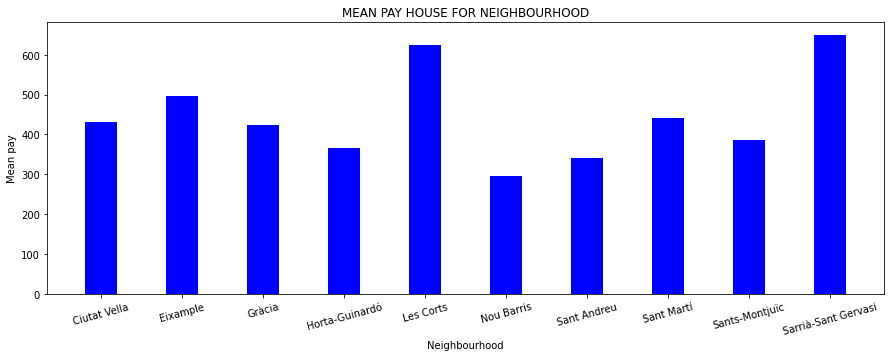

In [61]:
graph = pd.pivot_table(data = df_quarter,
                       index=['neighbourhood_group_cleansed'],
                       #columns = "ASSET_LOCATION",
                       values=["price_house"], 
                       aggfunc="mean",
                       )

graph = graph.reset_index()

fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(graph.neighbourhood_group_cleansed, graph.price_house, color ='blue',
        width = 0.4)
 
plt.xlabel("Neighbourhood")
plt.xticks(fontsize=10, rotation=15)
plt.ylabel("Mean pay")
plt.title("MEAN PAY HOUSE FOR NEIGHBOURHOOD")
plt.show()


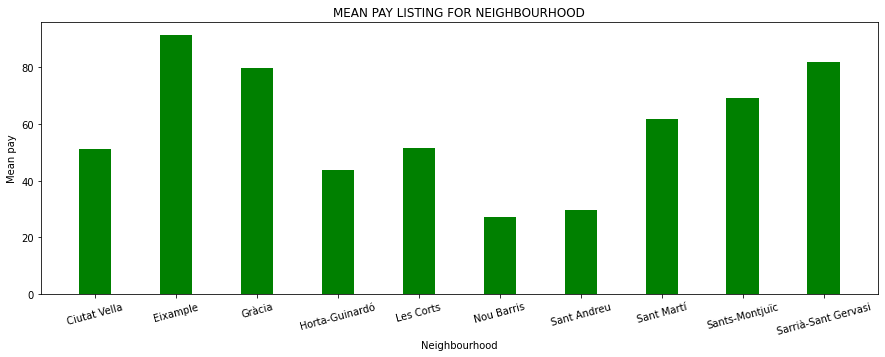

In [62]:
graph = pd.pivot_table(data = df_quarter,
                                  index=['neighbourhood_group_cleansed'],
                                  #columns = "ASSET_LOCATION",
                                  values=["price"], 
                                  aggfunc="mean",
                                  )

graph = graph.reset_index()

fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(graph.neighbourhood_group_cleansed, graph.price, color ='green',
        width = 0.4)
 
plt.xlabel("Neighbourhood")
plt.xticks(fontsize=10, rotation=15)
plt.ylabel("Mean pay")
plt.title("MEAN PAY LISTING FOR NEIGHBOURHOOD")
plt.show()

### Correlation

In [44]:
df_quarter.head(2)

,neighbourhood_group_cleansed,quarter,reviewer_id,price_house,price
0,Ciutat Vella,1,2498,415.0525,50.0
1,Ciutat Vella,2,8894,426.7700,50.0


In [45]:
np.unique(df_quarter['quarter'])

array([1, 2, 3, 4])

In [ ]:
fig, axes = plt.subplots(1,4)
sub = []
corr = round(df_quarter.price.corr(df_quarter.price_house), 2)
fig.suptitle('Correlation between price house and price listing: {}'.format(corr), fontsize=24)

# calculate the correlation matrix
for quarter in np.unique(df_quarter['quarter']):
    df_graph = df_quarter[df_quarter['quarter'] == quarter]
    corr = df_graph[['price','price_house']].corr()
    g = sns.heatmap(corr, 
                    xticklabels = corr.columns,
                    yticklabels = corr.columns,
                    ax=axes[quarter % 4])
    g.set_title('Quarter' + ':'+ str(quarter))
    g

In [ ]:
fig, axes = plt.subplots(1,4)
sub = []

corr = round(df_quarter.reviewer_id.corr(df_quarter.price_house), 2)
fig.suptitle('Correlation between price house and number contract: {}'.format(corr), fontsize=24)

# calculate the correlation matrix
for quarter in np.unique(df_analysis['quarter']):
    df_graph=df_analysis[df_analysis['quarter']== quarter]
    corr = df_graph[['reviewer_id','price_house']].corr()
    g=sns.heatmap(corr,
                  xticklabels = corr.columns,
                  yticklabels = corr.columns,
                  ax = axes[quarter % 4])
    g.set_title('Quarter' + ':'+ str(quarter))
    g

In [46]:
df_analysis.groupby('neighbourhood_group_cleansed')[['price','price_house']].corr()

price  price_house
neighbourhood_group_cleansed                                   
Ciutat Vella                 price        1.000000     0.031814
                             price_house  0.031814     1.000000
Eixample                     price        1.000000     0.021410
                             price_house  0.021410     1.000000
Gràcia                       price        1.000000     0.018204
                             price_house  0.018204     1.000000
Horta-Guinardó               price        1.000000     0.012236
                             price_house  0.012236     1.000000
Les Corts                    price        1.000000    -0.032448
                             price_house -0.032448     1.000000
Nou Barris                   price        1.000000     0.108321
                             price_house  0.108321     1.000000
Sant Andreu                  price        1.000000     0.023244
                             price_house  0.023244     1.000000
Sant Martí                   price        1.000000     0.043757
                             price_house  0.043757     1.000000
Sants-Montjuïc               price        1.000000     0.004364
                             price_house  0.004364     1.000000
Sarrià-Sant Gervasi          price        1.000000     0.065692
                             price_house  0.065692     1.000000

In [47]:
df_analysis.groupby('neighbourhood_group_cleansed')[['reviewer_id','price_house']].corr()

reviewer_id  price_house
neighbourhood_group_cleansed                                      
Ciutat Vella                 reviewer_id     1.000000     0.081885
                             price_house     0.081885     1.000000
Eixample                     reviewer_id     1.000000     0.096029
                             price_house     0.096029     1.000000
Gràcia                       reviewer_id     1.000000     0.000328
                             price_house     0.000328     1.000000
Horta-Guinardó               reviewer_id     1.000000     0.084397
                             price_house     0.084397     1.000000
Les Corts                    reviewer_id     1.000000     0.053323
                             price_house     0.053323     1.000000
Nou Barris                   reviewer_id     1.000000     0.121469
                             price_house     0.121469     1.000000
Sant Andreu                  reviewer_id     1.000000     0.084367
                             price_house     0.084367     1.000000
Sant Martí                   reviewer_id     1.000000     0.104957
                             price_house     0.104957     1.000000
Sants-Montjuïc               reviewer_id     1.000000     0.089964
                             price_house     0.089964     1.000000
Sarrià-Sant Gervasi          reviewer_id     1.000000     0.074394
                             price_house     0.074394     1.000000